<a href="https://colab.research.google.com/github/erbisti/Collab/blob/main/MLP_SVM_RAFOR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Acurácia Random Forest: 0.5867
Acurácia SVM:           0.6300
Acurácia MLP (Keras):   0.6400


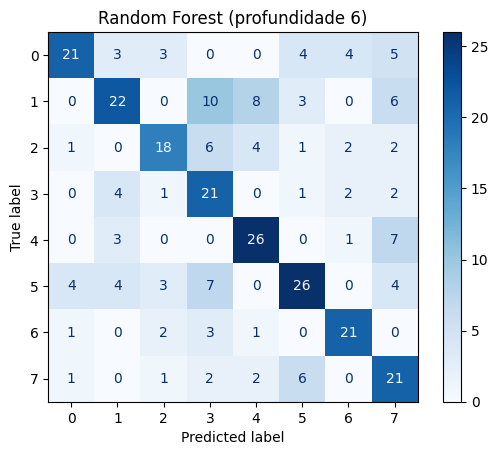

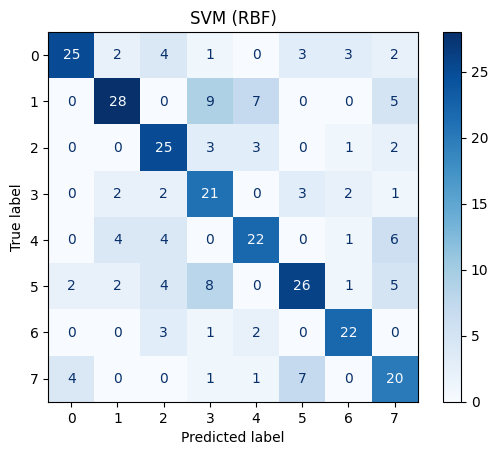

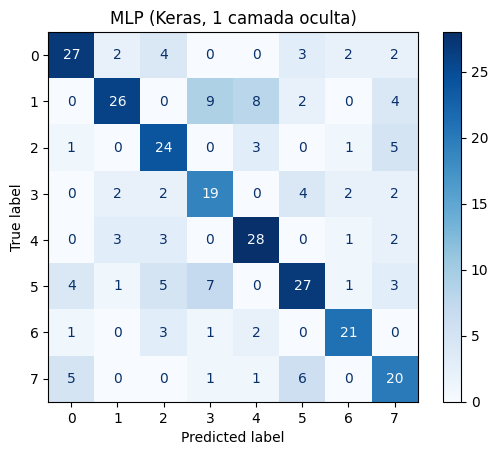

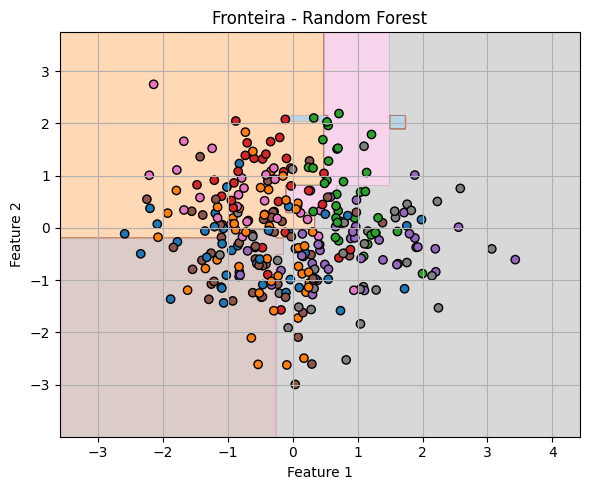

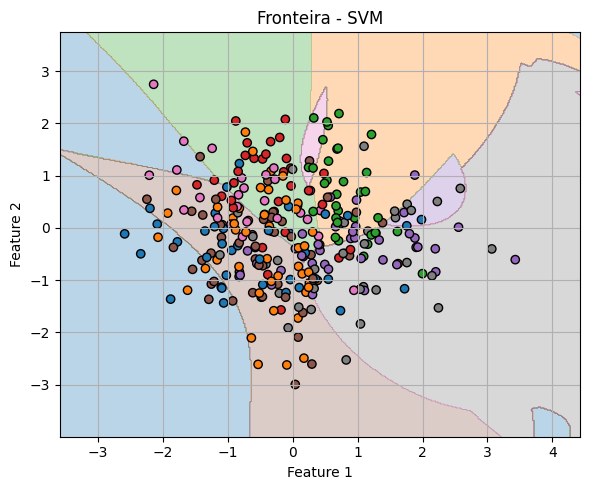

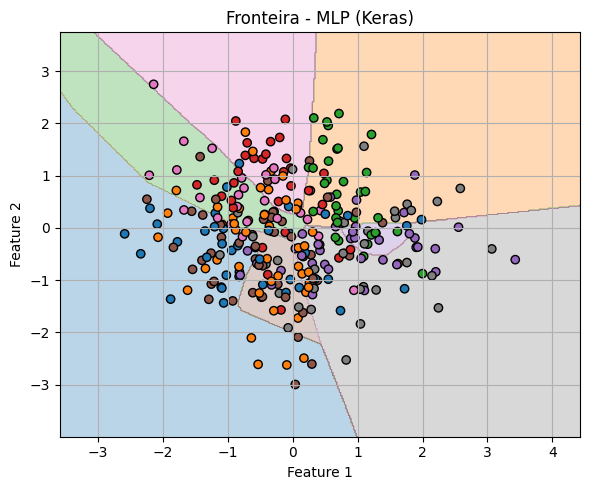

In [1]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.utils import to_categorical

# 1. Geração do dataset com 8 classes e 8 features
X, y = make_classification(
    n_samples=1000,
    n_features=8,
    n_informative=4,  # 4 variáveis realmente úteis para classificar
    n_redundant=0,    # nenhuma variável redundante
    n_classes=8,
    n_clusters_per_class=1,
    random_state=37
)

# 2. Divisão dos dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=37)

# 3. Padronização dos dados para melhorar a performance dos modelos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 4. Treinamento dos modelos

# Random Forest com 10 árvores de profundidade máxima 6
rf = RandomForestClassifier(n_estimators=10, max_depth=6, random_state=42)
rf.fit(X_train_scaled, y_train)
rf_pred = rf.predict(X_test_scaled)
rf_acc = accuracy_score(y_test, rf_pred)

# Suporte Vector Machine com kernel RBF
svm = SVC(kernel='rbf', decision_function_shape='ovr', random_state=42)
svm.fit(X_train_scaled, y_train)
svm_pred = svm.predict(X_test_scaled)
svm_acc = accuracy_score(y_test, svm_pred)

# MLP com Keras (1 camada oculta com 30 neurônios e ativação ReLU)
y_train_cat = to_categorical(y_train, num_classes=8)
y_test_cat = to_categorical(y_test, num_classes=8)

model = Sequential([
    Input(shape=(X_train_scaled.shape[1],)),  # define forma de entrada corretamente
    Dense(30, activation='relu'),
    Dense(8, activation='softmax')  # saída com 8 classes
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train_scaled, y_train_cat, epochs=50, batch_size=32, verbose=0)

# Geração de predições e cálculo da acurácia
mlp_probs = model.predict(X_test_scaled)
mlp_pred = np.argmax(mlp_probs, axis=1)
mlp_acc = accuracy_score(y_test, mlp_pred)

# 5. Resultados de acurácia
print(f"Acurácia Random Forest: {rf_acc:.4f}")
print(f"Acurácia SVM:           {svm_acc:.4f}")
print(f"Acurácia MLP (Keras):   {mlp_acc:.4f}")

# 6. Visualização das matrizes de confusão
def plot_confusion(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues, values_format='d')
    plt.title(title)
    plt.show()

plot_confusion(y_test, rf_pred, "Random Forest (profundidade 6)")
plot_confusion(y_test, svm_pred, "SVM (RBF)")
plot_confusion(y_test, mlp_pred, "MLP (Keras, 1 camada oculta)")



# 7. Plotar fronteiras de decisão (usando apenas as 2 primeiras variáveis padronizadas para visualização)
from matplotlib.colors import ListedColormap

def plot_decision_boundary_2d(model, X, y, title, is_keras=False):
    # Apenas as duas primeiras features
    X_vis = X[:, :2]

    # Geração da malha
    h = 0.02
    x_min, x_max = X_vis[:, 0].min() - 1, X_vis[:, 0].max() + 1
    y_min, y_max = X_vis[:, 1].min() - 1, X_vis[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    X_grid = np.c_[xx.ravel(), yy.ravel()]

    # Expandir para o tamanho original se necessário (com zeros nas dimensões faltantes)
    X_full = np.zeros((X_grid.shape[0], X.shape[1]))
    X_full[:, :2] = X_grid

    # Predição
    if is_keras:
        Z = np.argmax(model.predict(X_full, verbose=0), axis=1)
    else:
        Z = model.predict(X_full)

    Z = Z.reshape(xx.shape)

    # Plot
    cmap = ListedColormap(plt.cm.tab10.colors[:len(np.unique(y))])
    plt.figure(figsize=(6, 5))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=cmap)
    scatter = plt.scatter(X_vis[:, 0], X_vis[:, 1], c=y, cmap=cmap, edgecolor='k')
    plt.title(title)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Gerar gráficos de fronteiras
plot_decision_boundary_2d(rf, X_test_scaled, y_test, "Fronteira - Random Forest")
plot_decision_boundary_2d(svm, X_test_scaled, y_test, "Fronteira - SVM")
plot_decision_boundary_2d(model, X_test_scaled, y_test, "Fronteira - MLP (Keras)", is_keras=True)

